BACKGROUND INFO

There are 10 types of faults, linked to each bearing defect:
    Ball_007_1: Ball defect (0.007 inch)
    Ball_014_1: Ball defect (0.014 inch)
    Ball_021_1: Ball defect (0.021 inch)
    IR_007_1: Inner race fault (0.007 inch)
    IR_014_1: Inner race fault (0.014 inch)
    IR_021_1: Inner race fault (0.021 inch)
    Normal_1: Normal
    OR_007_6_1: Outer race fault (0.007 inch, data collected from 6 O'clock position)
    OR_014_6_1: Outer race fault (0.014 inch, 6 O'clock)
    OR_021_6_1: Outer race fault (0.021 inch, 6 O'clock)
    
Raw data files are in .mat format contained in /raw. Each data file is 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.fft import fft, fftfreq
import scipy.io as sio

RAW_FILES = 'raw/'
# SENSOR_NAMES = ['X098_DE_time', 'X098_FE_time', 'X123_DE_time', 'X123_FE_time', 'X190_DE_time', 'X190_FE_time', 'X227_DE_time', 'X227_FE_time',
#                  'X110_DE_time', 'X110_FE_time', 'X175_DE_time', 'X175_FE_time', 'X214_DE_time', 'X214_FE_time',
#                  'X136_DE_time', 'X136_FE_time', 'X202_DE_time', 'X202_FE_time', 'X239_DE_time', 'X239_FE_time']
SENSOR_NAMES = ['X098_DE_time', 'X123_DE_time', 'X190_DE_time', 'X227_DE_time', 
                'X110_DE_time', 'X175_DE_time', 'X214_DE_time', 'X136_DE_time', 
                'X202_DE_time', 'X239_DE_time']
SAMPLING_RATE = 12000 
TIME_STEP = 1 / SAMPLING_RATE
SEGMENT_LENGTH = 2048

In [2]:
def transform(data):
    y = fft(data)  # 1D discrete Fourier transform (DFT) of data
    y =  2/sample_points * np.abs(y[0:sample_points//2]) # multiplying by 2/sample_points to convert to dB for normalization
    x = fftfreq(sample_points, TIME_STEP)[:sample_points//2]  # sample frequencies
    return x, y

Calculate PSD from signal. 

In [3]:
import scipy.signal as signal

def get_psd(data, bin_width, name):
    f, psd = signal.welch(data, fs=SAMPLING_RATE, window='hann', nperseg=SAMPLING_RATE/bin_width, axis=0)
    df_psd = pd.DataFrame(psd, columns=[name])
    df_psd['Frequency (Hz)'] = f
    df_psd = df_psd.set_index('Frequency (Hz)')
    return df_psd.iloc[1:]   # drop the first value because it makes the plots look bad and is effectively 0

Extract statistical features from non-normalized signal segments. 

In [4]:
def extract_features(data) -> pd.DataFrame:
    column_names = ['Standard deviation', 'Mean', 'Variance', 'Peak-to-peak factor', 'RMS', 'Crest factor', 'Kurtosis', 'Skewness']
    std_values = []
    mean_values = []
    var_values = []
    pp_values = []
    rms_values = []
    crest_values = []
    kurtosis_values = []
    skew_values = []
    
    for i in range(0, len(data), SEGMENT_LENGTH):
        segment = y_fft[i:i+SEGMENT_LENGTH]
        
        std = np.std(segment)  # Standard Deviation
        std_values.append(std)
        
        mean_signal = np.mean(segment)  # Mean
        mean_values.append(mean_signal)
        
        variance = np.var(segment)  # Variance
        var_values.append(variance)
        
        pp = np.max(segment) - np.min(segment)  # Peak-to-peak factor
        pp_values.append(pp)
        
        rms = np.sqrt(np.mean(segment**2))  # RMS
        rms_values.append(rms)
        
        crest = np.max(segment) / rms  # Crest factor
        crest_values.append(crest)
        
        kurtosis = pd.Series(segment).kurt()  # Kurtosis
        kurtosis_values.append(kurtosis)
        
        skew = pd.Series(segment).skew()  # Skewness
        skew_values.append(skew)
        
    calculated_stats = pd.DataFrame(list(zip(std_values, mean_values, var_values, pp_values, 
                                             rms_values, crest_values, kurtosis_values, skew_values)), columns=column_names)
    return calculated_stats

Analysing file: B007_1_123.mat
Number of sample points in file: 487384
Analysing file: B014_1_190.mat
Number of sample points in file: 486224
Analysing file: B021_1_227.mat
Number of sample points in file: 486804
Analysing file: IR007_1_110.mat
Number of sample points in file: 486224
Analysing file: IR014_1_175.mat
Number of sample points in file: 381890
Analysing file: IR021_1_214.mat
Number of sample points in file: 485063
Analysing file: OR007_6_1_136.mat
Number of sample points in file: 486804
Analysing file: OR014_6_1_202.mat
Number of sample points in file: 484483
Analysing file: OR021_6_1_239.mat
Number of sample points in file: 489125
Analysing file: Time_Normal_1_098.mat
Number of sample points in file: 483903


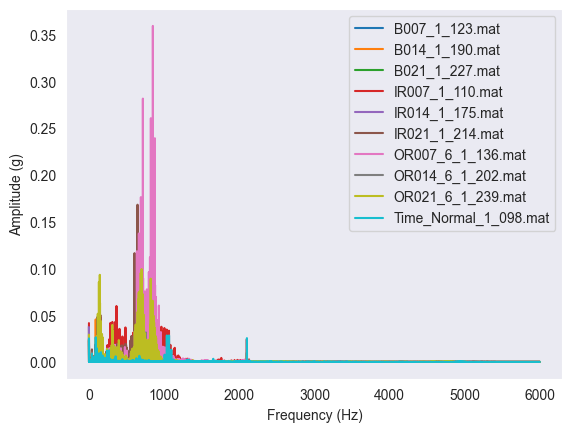

In [5]:
import plotly.express as px

files = []
frames = []
psd_frames = []
labeled_data = pd.DataFrame()
psd_data = pd.DataFrame()
plt.figure()
fig = px.line()

for file in os.listdir(RAW_FILES):
    files.append(file)
    raw_dict = sio.loadmat(RAW_FILES + file)  # load raw data file in .mat format
    for i in range(len(SENSOR_NAMES)):
        sensor = SENSOR_NAMES[i]
        if sensor in raw_dict:
            time_series = raw_dict[sensor].flatten()  # extract time series for one of the accelerometers and convert 2D array to 1D array
            sample_points = len(time_series)
            fs = sample_points / (time_series[-1] - time_series[0])
            print('Analysing file: ' + file)
            print('Number of sample points in file: ' + str(sample_points))
            x_fft, y_fft = transform(time_series)  # FFT transform
            features = extract_features(y_fft)
            features['Fault type'] = file[:-10]
            frames.append(features)
            labeled_data = pd.concat(frames, ignore_index=True)
            plt.plot(x_fft, y_fft, label=file)  # Plot FFT results
            
            df_psd = get_psd(time_series, 1, file)  # Calculate PSD for all files
            psd_frames.append(df_psd)
            psd_data = pd.concat(psd_frames, ignore_index=True, axis=1)

psd_data.columns = files
fig = px.line(psd_data, labels={'value': 'Acceleration (g^2/Hz)'}, log_x=True, log_y=True)  # Plot PSD results for all files
fig.show()

plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (g)')
plt.legend()
plt.show()
plt.close()

Plot features. 

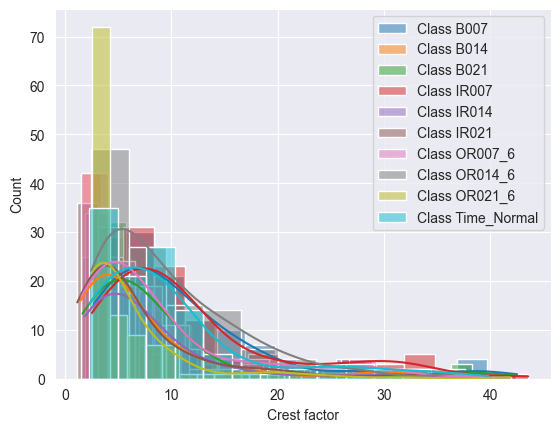

In [6]:
import seaborn as sns

labeled_data.to_csv('CWRU_preprocessed_labeled.csv', index=False)

TARGET = 'Fault type'
FEATURES_LIST = list(labeled_data.columns)
FEATURES_LIST.remove(TARGET)

for class_value in labeled_data[TARGET].unique():
    filtered_df = labeled_data[labeled_data[TARGET] == class_value]
    sns.histplot(filtered_df['Crest factor'], kde=True, label=f'Class {class_value}')
    plt.ylabel('Count')
    plt.legend()

Feature selection.

In [7]:
# from sklearn.feature_selection import SelectKBest, f_classif
# 
# x = labeled_data.drop([TARGET], axis=1)
# y = labeled_data[TARGET]
# y = y.to_frame(name=TARGET)
# 
# selector = SelectKBest(score_func=f_classif, k=5)
# x_new = selector.fit_transform(x, y)
# 
# selected_indices = selector.get_support(indices=True)
# print(selected_indices)
# selected_features = FEATURES_LIST[selected_indices]
# 
# scores = selector.scores_
# 
# plt.bar(range(len(FEATURES_LIST)), scores, tick_label=FEATURES_LIST)
# plt.xticks(rotation=90)
# plt.xlabel('Features')
# plt.ylabel('Score')
# plt.show()
# 
# print('Selected features: ' + selected_features)